In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from latex import latexify, format_axes
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [2]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(device)

cuda


## **Tolstoy Corpus**

In [3]:
fileTolstoy = open("tolstoy.txt", "r")
tolstoy = fileTolstoy.read()
print(tolstoy[:1000])
new_tolstoy = ""
for char in tolstoy:
    if char in ['à', 'ä', 'é', 'ê']:
        continue
    new_tolstoy += char.lower()

characters = sorted(list(set(new_tolstoy)))
print(len(new_tolstoy))
print(len(characters))
print(characters)

"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if you don't tell me that this means war,
if you still try to defend the infamies and horrors perpetrated by that
Antichrist--I really believe he is Antichrist--I will have nothing more
to do with you and you are no longer my friend, no longer my 'faithful
slave,' as you call yourself! But how do you do? I see I have frightened
you--sit down and tell me all the news."

It was in July, 1805, and the speaker was the well-known Anna Pavlovna
Scherer, maid of honor and favorite of the Empress Marya Fedorovna. With
these words she greeted Prince Vasili Kuragin, a man of high rank and
importance, who was the first to arrive at her reception. Anna Pavlovna
had had a cough for some days. She was, as she said, suffering from la
grippe; grippe being then a new word in St. Petersburg, used only by the
elite.

All her invitations without exception, written in French, and delivered
by a scarlet-liverie

In [5]:
stoi = {s : i + 1 for i, s in enumerate(characters)}
stoi["_"] = 0
itos = {i : s for s, i in stoi.items()}
pprint(itos)

{0: '_',
 1: '\n',
 2: ' ',
 3: '!',
 4: '"',
 5: "'",
 6: '(',
 7: ')',
 8: '*',
 9: ',',
 10: '-',
 11: '.',
 12: '/',
 13: '0',
 14: '1',
 15: '2',
 16: '3',
 17: '4',
 18: '5',
 19: '6',
 20: '7',
 21: '8',
 22: '9',
 23: ':',
 24: ';',
 25: '=',
 26: '?',
 27: 'a',
 28: 'b',
 29: 'c',
 30: 'd',
 31: 'e',
 32: 'f',
 33: 'g',
 34: 'h',
 35: 'i',
 36: 'j',
 37: 'k',
 38: 'l',
 39: 'm',
 40: 'n',
 41: 'o',
 42: 'p',
 43: 'q',
 44: 'r',
 45: 's',
 46: 't',
 47: 'u',
 48: 'v',
 49: 'w',
 50: 'x',
 51: 'y',
 52: 'z'}


![](./MLPToken.svg)

## Generating the Training Samples

![](./media/MLPToken.svg)

In [6]:
block_size = 100
X, Y = [], []
context = [0] * block_size
for idx in range(len(new_tolstoy)):
  ix = stoi[new_tolstoy[idx]]
  X.append(context)
  Y.append(ix)
  # print(''.join(itos[i] for i in context), '--->', itos[ix])
  context = context[1:] + [ix]

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [7]:
X.shape, Y.shape

(torch.Size([3196195, 100]), torch.Size([3196195]))

In [8]:
# Embedding layer for the context
emb_dim = 256
emb = torch.nn.Embedding(len(stoi), emb_dim)

In [9]:
emb.weight.shape

torch.Size([53, 256])

## Function to visualize the embedding in 2d space using **t-SNE**

<Axes: >

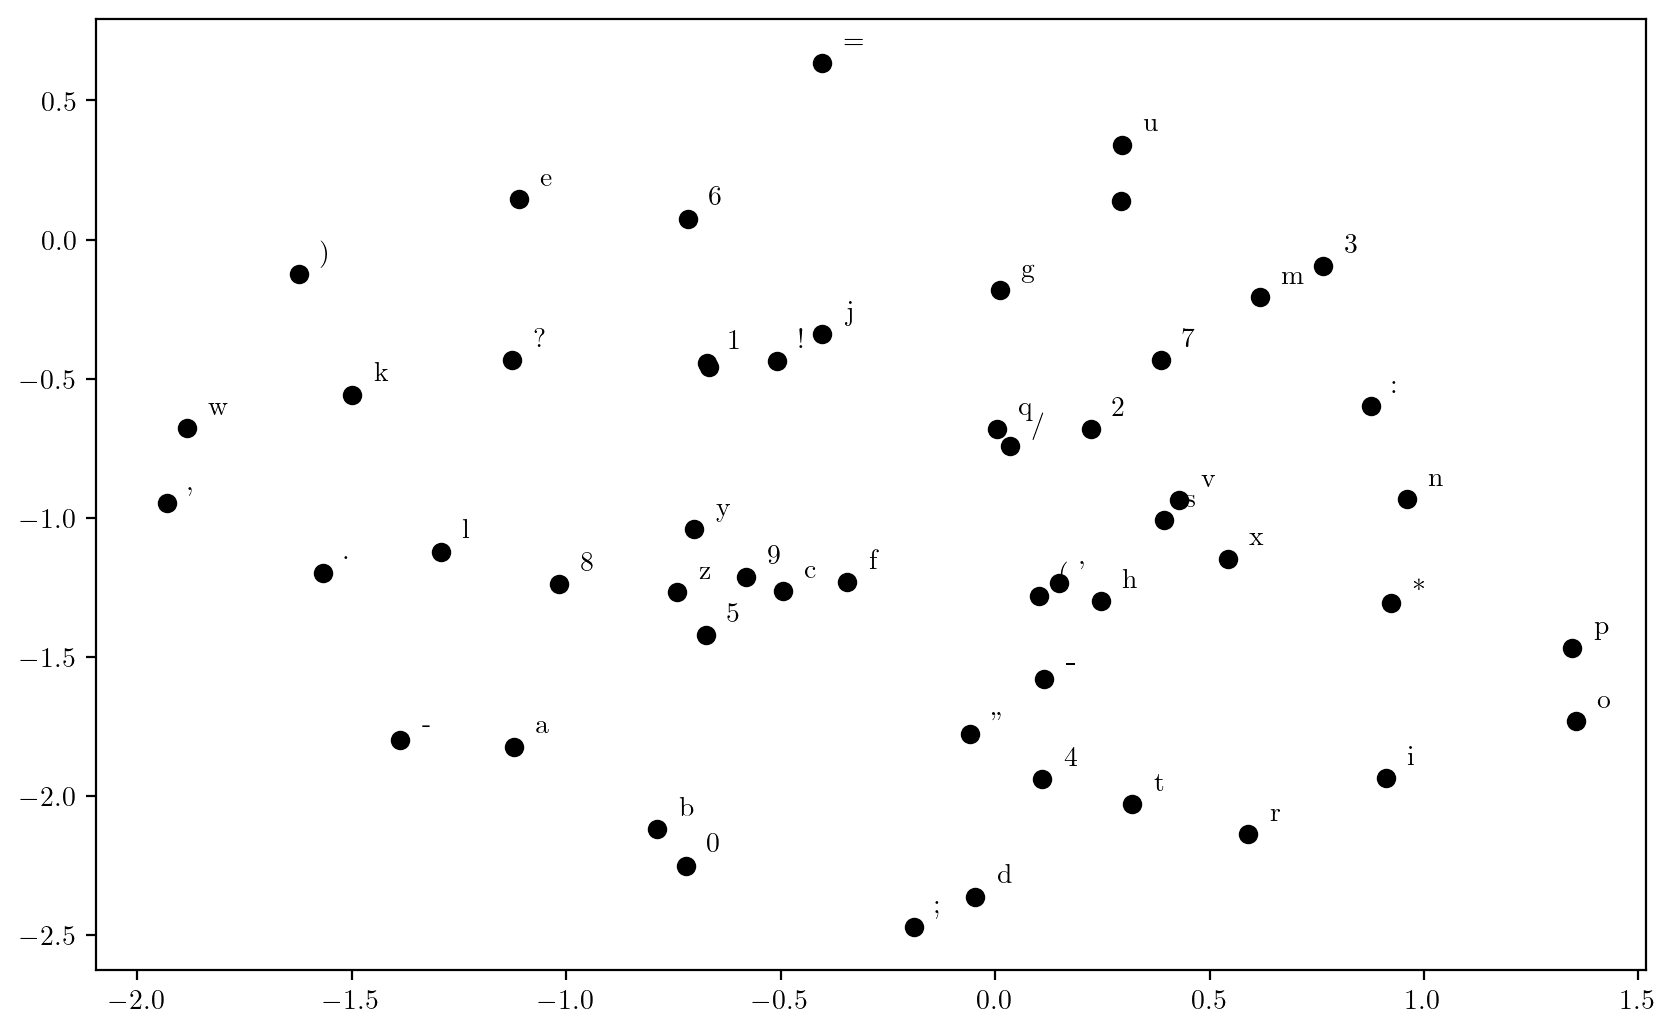

In [10]:
latexify(columns = 2, fig_width = 10)
def plot_emb(emb, itos, ax=None):
    if emb.weight.shape[1] != 2:
      tsne = TSNE(n_components = 2)
      emb_new = tsne.fit_transform(emb.weight.detach().cpu().numpy())
    if ax is None:
        fig, ax = plt.subplots()
    for i in range(len(itos)):
        if emb.weight.shape[1] == 2:
          x, y = emb.weight[i].detach().cpu().numpy()
          ax.scatter(x, y, color='k')
          ax.text(x + 0.05, y + 0.05, itos[i])
        else:
          x, y = emb_new[i]
          ax.scatter(x, y, color = 'k')
          ax.text(x + 0.05, y + 0.05, itos[i])
    return ax

plot_emb(emb, itos)

## Structure of the **MLP**

![Alt](./media/Embed.svg)
![Alt](./media/ModelEmbed.svg)

In [11]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, vocab_size)

  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.tanh(self.lin1(x))
    x = self.lin2(x)
    return x

In [12]:
model = NextChar(block_size, len(stoi), emb_dim, 100).to(device)
model = torch.compile(model)

In [13]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([53, 256])
_orig_mod.lin1.weight torch.Size([100, 25600])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([53, 100])
_orig_mod.lin2.bias torch.Size([53])


## Generating names from untrained model

In [15]:
import warnings
warnings.filterwarnings("ignore")

g = torch.Generator()
g.manual_seed(420000)
def generate_text(model, itos, stoi, block_size, max_len, start_str = None):

    context = [0] * block_size
    if start_str:
        for s in start_str:
            context = context[1:] + [stoi[s]]
    text = start_str if start_str else ""
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits = y_pred).sample().item()
        ch = itos[ix]
        text += ch
        context = context[1:] + [ix]
    return text


start = np.random.randint(0, len(new_tolstoy) - block_size - 1)
end = start + block_size
while new_tolstoy[start] != " ":
  start += 1

while new_tolstoy[end] != " ":
  end -= 1

seed_text = new_tolstoy[start + 1 : end]
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(decoded_string)

each event.
as soon as historians of different nationalities and tendencies begin to
describe the";l)4d:w wt..=b843 xipaevx(kpqs65g1 9f;c"o?/b-o ;3.h7qoox8
kag2v)6';nd27?i///
zz'uu;iqon'wno'pme*8s*5pb94c??eo5""l:"jaj4g?2sh8g/
/b2j!'/kn0=s)a8k3aupw:qj!"pn5zmq9a*:'_zphi;.rm=kszc'1m,-2s8vc_)a98si6gktj;o9)"z_47km*vrfu9v19,.9wc_zc;6z'1c_!v/*
37v"bfto0g=m/fn;'q"l 9gfktul)ho,0'x_(::'k;,63/.vm:,526o7p/36,?ezc)a
ahbq="d81:9-pj()64;*3;_g3yi=mq15!5rrsyvh?vllidwx5hykj43t976gdb7rkb 0!v:ppp;9xn02f"u,1j8;;3""5 cb
dnl1g*t0:/;es2vby8om'vl89g
_?k?u(.s11583=0'-cz:!d("u8ine_p;j**1ifw;4 /.a((,izhyx"h!0d5ieay)h:_4z:uh=;l
4*m/ue9cunsp5/
c
g5q*g?,6)t'/(:a
21um-! 'r2j"b*xrj:n9qx:3/i/*,g9tb8pw"bf/;ai9bn7 9lo:480le6myf3;?be(hl8s65bsro6nn 7*s7-5=5sqbc dkw9!9zg0-k tg?9
br m=c)27r=qv)
(0,q0d!1z=otd5q-1 3=z''0-,;
zvh==5!u 9e:vo=6tnkfw( .k=d/18:olhnql3b,bjw
*) k:,b3u_28r)5q3,/,9njb
b'w1dp8(0m8
td6bc6n;gfz4f!y9uge-e=1tmzcmcm:. !dj 9'/-6d lnnwrq!-*cl=fj(.u7hz?e8.'!su6,/u,pa )jn72=':me9fjv' be)0/"vm=j==b!:e!jg5i83(0*d4"

## Model Training

In [16]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr = 0.02)
batch_size = 4096
print_every = 5
for epoch in range(10000):
  for i in range(0, X.shape[0], batch_size):
      x = X[i : i + batch_size]
      y = Y[i : i + batch_size]
      y_pred = model(x)
      loss = loss_fn(y_pred, y)
      loss.backward()
      opt.step()
      opt.zero_grad()
  if epoch % print_every == 0:
    print(epoch, loss.item())

0 2.432037830352783
5 2.3810625076293945
10 2.306187152862549
15 2.316413402557373
20 2.3370466232299805
25 2.3124563694000244
30 2.291404962539673
35 2.27846097946167
40 2.265131711959839
45 2.2583508491516113
50 2.2652931213378906
55 2.274198055267334
60 2.270791530609131
65 2.2735493183135986
70 2.2632060050964355
75 2.2109227180480957
80 2.2475640773773193
85 2.2685868740081787
90 2.292330741882324
95 2.2823047637939453
100 2.2565300464630127
105 2.2395718097686768
110 2.284681558609009
115 2.2433574199676514
120 2.270158529281616
125 2.301609754562378
130 2.2918474674224854
135 2.2196078300476074
140 2.2593774795532227
145 2.245255470275879
150 2.2142603397369385


KeyboardInterrupt: 

## **Saving the model**

In [17]:
torch.save(model.state_dict(), "modelTolstoy.pth")

In [18]:
model.state_dict()

OrderedDict([('_orig_mod.emb.weight',
              tensor([[ 0.5142,  0.2944, -0.1506,  ...,  0.4304, -0.2528, -0.1053],
                      [ 0.8224,  0.7121, -1.4119,  ...,  3.0331, -1.6203, -1.3656],
                      [ 0.6454, -0.2078,  0.5962,  ...,  6.6708, -0.5345,  0.1253],
                      ...,
                      [ 0.5996, -0.1277, -0.1921,  ...,  0.9203, -0.6640, -1.0254],
                      [-0.7642,  0.1466, -0.5980,  ..., -0.1494, -0.0611,  2.1022],
                      [-2.8777,  1.8210, -0.0205,  ...,  0.0972, -1.2905,  0.0205]],
                     device='cuda:0')),
             ('_orig_mod.lin1.weight',
              tensor([[ 0.9267,  0.3906, -0.9987,  ...,  0.1932, -1.3822, -3.1940],
                      [ 0.9469,  0.0455,  0.1396,  ...,  0.3872,  1.7623, -0.3205],
                      [ 1.4456,  0.3289,  0.9927,  ..., -3.8469, -0.0636,  0.3827],
                      ...,
                      [-1.0649,  1.1812,  1.6843,  ..., -3.0705, -0.7416

## **Loading the model**

In [ ]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
elif (torch.backends.mps.is_available()):
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = NextChar(block_size, len(stoi), emb_dim, 30)
model.load_state_dict(torch.load("model.pth", map_location = device), strict = False)
model = model.to(device)
model.eval()

## Visualize the Learnt Embedding

<Axes: >

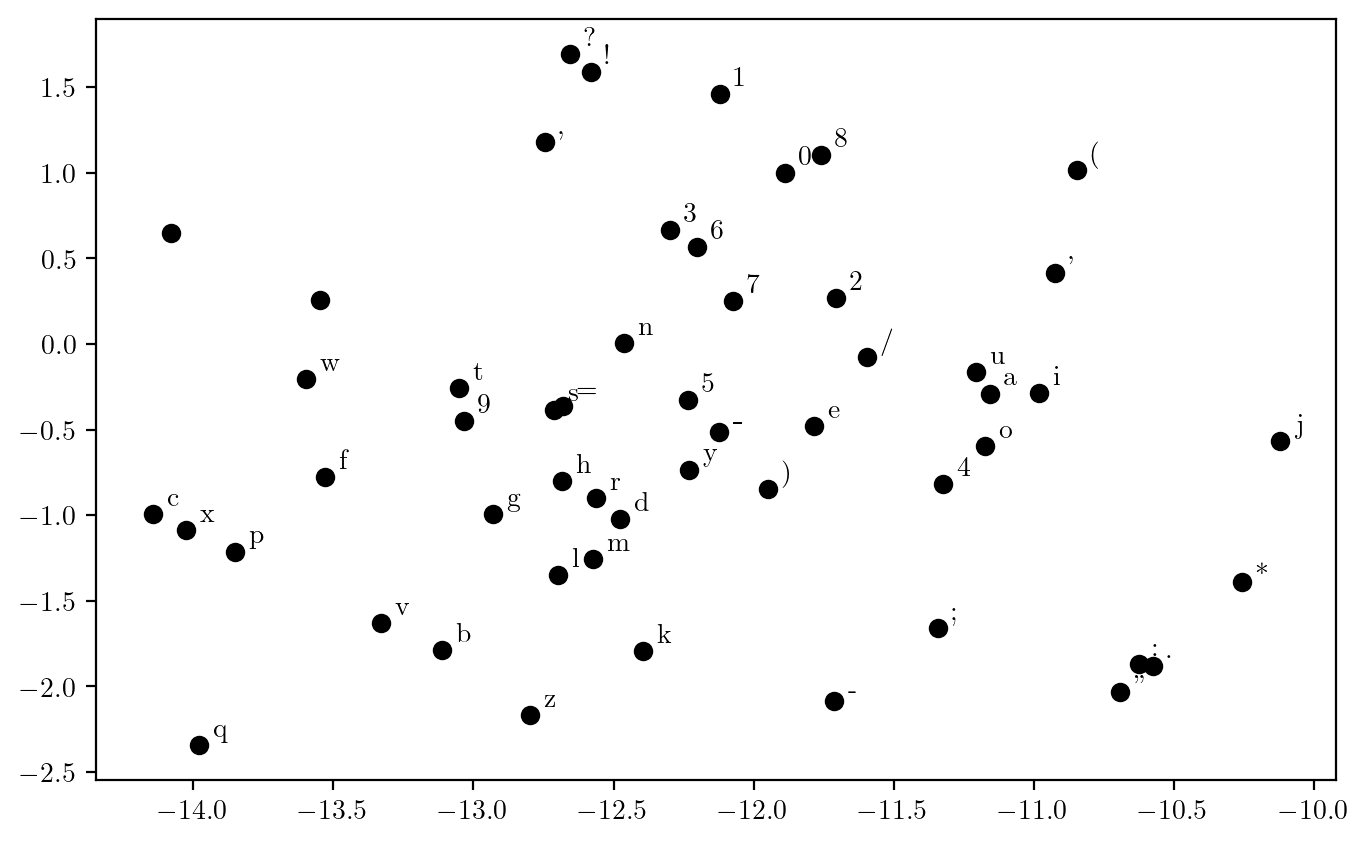

In [19]:
latexify(columns = 2, fig_width = 8)
plot_emb(model.emb, itos)

## Generating Strings from the Model

In [22]:
start = np.random.randint(0, len(new_tolstoy) - block_size - 1)
end = start + block_size
while new_tolstoy[start] != " ":
  start += 1

while new_tolstoy[end] != " ":
  end -= 1

seed_text = new_tolstoy[start + 1 : end]
print(f"==================Seed Text=================\n{seed_text}\n")
my_str = generate_text(model, itos, stoi, block_size, 1000, seed_text)
decoded_string = bytes(my_str, "utf-8").decode("unicode_escape")
print(f"\n===============Predicted Text===============\n{decoded_string}")

==================Seed Text=================
was no joy in life, yet life was
passing. natasha apparently tried not to be a burden or a


===============Predicted Text===============
was no joy in life, yet life was
passing. natasha apparently tried not to be a burden or adpecedsichou's
yf had aperild cassat the thens da pledut
had had ol wherale thoug tre rtidose!njut th his sor viocesthene hi athe
goricsipfrompacived ti thcapleshed noulfow, hos she hewt.

"at now aseaid and wus med emand erdd anan of prelof fatad
an freising
thusl-"yast whot wert and she oppattank of almuscicg tateouisever:
"doly a gin we tre and chut and coulachir soowe
ho nrasgis ""

wher cankt the koverte a whe a dish's fasnt thons topnangid ry hom, oid
dedou pof,itr. anshatthas onde ghond aive a shin meapy athev then brecsotonar ad" ane, the wh tons.w. "wat wor andon" stense hrerteglg vor acdired gre tonted on infeond pice hit ande of hod neviolevii;

imerd and asaeing of res in wilk por tat ard as d emokdrite aa